# Figure 7: MACM correspondence to cerebral and subcortical parcellations.

## We show how the meta-analytic conenctivity modeling (MACM) results correspond to subcortical areas (Tian et al. 2020), and to cerebral parcellations (Ji et al. 2019 for functional, Von Economo cortical types/ Saberi et al. 2023 for structural)

### Author: Neville Magielse
#### Date: 15.08.2024

In [1]:
import os
import sys

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))


In [2]:
# Imports
import pandas as pd
import nibabel
import nilearn
import nilearn.plotting, nilearn.maskers, nilearn.image
import nilearn.surface
import numpy as np

from pprint import pprint
import itertools
import scipy
import scipy.spatial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns

import nimare
from nimare.meta.cbma.ale import ALE, SCALE
from nimare.utils import vox2mm, mm2vox
from nimare_gpu.ale import DeviceALE, DeviceSCALE, DeviceMixin
from nimare.correct import FWECorrector

import argparse
from numba import cuda
import json
import glob

import warnings
warnings.simplefilter('ignore')

import neuromaps
import neuromaps.nulls

import tempfile

import hcp_utils as hcp
import re
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [3]:
# Only list valid Domains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
domains = ['Action']

In [4]:
# Only list valid Subdomains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
subdomains = ['Execution', 'Execution.Speech', 'Memory.Working', 'Vision']


In [5]:
subdomains_exps = {'Execution': 251,
                   'Execution.Speech': 80, 
                   'Memory.Working': 21,
                   'Vision': 34}

In [6]:
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Action.Execution': 'Execution',
    'Action.Execution.Speech': 'Speech Execution',
    'Cognition.Memory.Working': 'Working Memory',
    'Perception.Vision': 'Vision'
})

# Start with the subcortical comparison

# Load Tian et al. (2020) subcortical parcellation
## And resample it to the mask of the MACM data

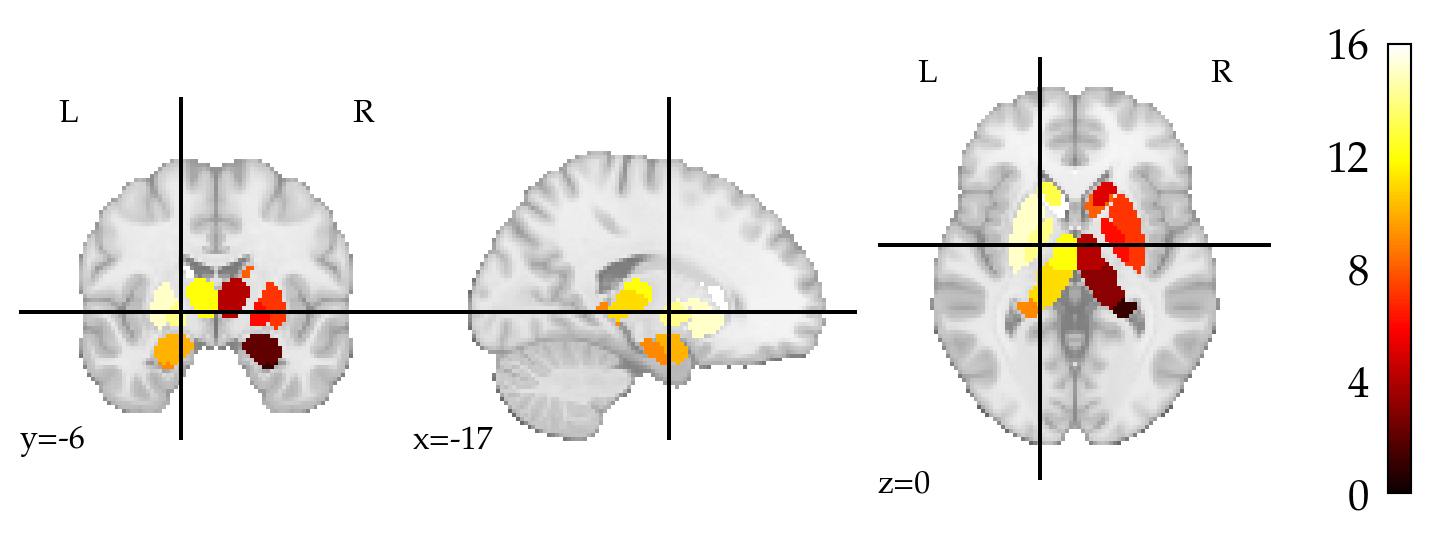

In [7]:
tian = nibabel.load(os.path.join(INPUT_DIR,'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask)
nilearn.plotting.plot_stat_map(tian_2mm)

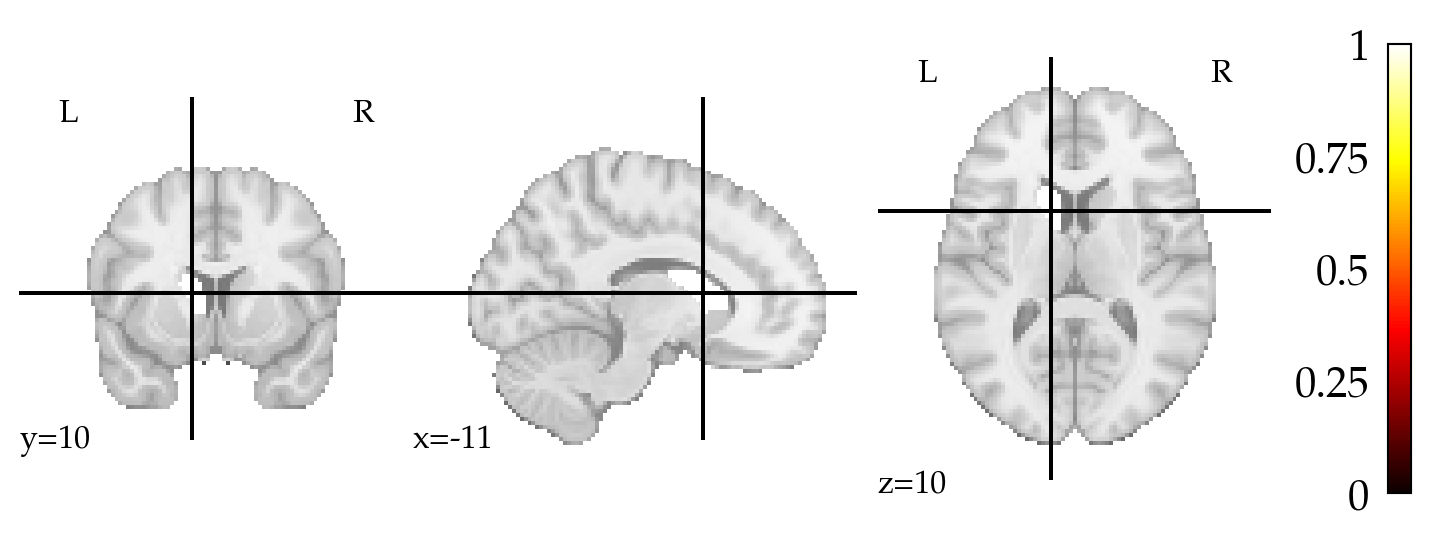

In [8]:
# Plot a single, example, parcel and check if it is symmetric.
nilearn.plotting.plot_stat_map(nilearn.image.math_img('a == 16', a=tian_2mm))

In [9]:
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Action/Action/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [10]:
counts = pd.DataFrame({
    'macm': macm_bin.get_fdata().flatten(),
    'tian': tian_2mm.get_fdata().flatten() 
}).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]
counts

tian
0.0     7735
3.0       26
4.0       66
6.0        1
7.0       65
11.0     177
12.0     130
14.0       1
15.0     208
Name: count, dtype: int64

# Loop over domains

In [11]:
counts = {}

for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # todo: use re
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    # binarize
    macm_bin = nilearn.image.binarize_img(macm_path)
    # counts
    counts[subbd] = pd.DataFrame({
        'macm': macm_bin.get_fdata().flatten(),
        'tian': tian_2mm.get_fdata().flatten() 
    }).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]

counts = pd.DataFrame(counts).sort_index()

# Define the list of valid subdomains
valid_MACMs = ['Action', 'Action.Execution', 'Action.Execution.Speech', 'Cognition.Memory.Working', 'Perception.Vision']

# Filter the counts DataFrame to only keep the columns in the valid subdomains list
counts = counts.loc[:, counts.columns.intersection(valid_MACMs)]

# Display the filtered DataFrame
counts

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Action.Execution.Speech  Action.Execution  Action  \
tian                                                      
0.0                    3792.0              8151    7735   
3.0                       NaN                30      26   
4.0                       NaN                88      66   
6.0                       5.0                 2       1   
7.0                      81.0                61      65   
11.0                     56.0               177     177   
12.0                     65.0               124     130   
14.0                     11.0                 3       1   
15.0                     55.0               213     208   

      Cognition.Memory.Working  Perception.Vision  
tian                                               
0.0                      806.0             1302.0  
3.0                        NaN                NaN  
4.0                        NaN                NaN  
6.0                        NaN                NaN  
7.0                        NaN                NaN  
11.0                       NaN                NaN  
12.0                       NaN                NaN  
14.0                       NaN                NaN  
15.0                       NaN                NaN

9 rows (Tian Parcels + background) x 5 colums (Valid MACM analyses)..
Drop anything non-subcortical (0.0) and calculate percentages.

In [22]:
counts_sctx = counts.drop(index=0.0).fillna(0)

In [23]:
pct = (counts_sctx / counts_sctx.values.sum(axis=0, keepdims=True)) * 100
# drop NaNs (no subcortical voxels in MACM)
pct = pct.dropna(axis=1)

In [24]:
labels = np.loadtxt(os.path.join(INPUT_DIR,
    'maps/Tian_Subcortex_S1_3T_label.txt'),
    dtype=str
)
labels

array(['HIP-rh', 'AMY-rh', 'pTHA-rh', 'aTHA-rh', 'NAc-rh', 'GP-rh',
       'PUT-rh', 'CAU-rh', 'HIP-lh', 'AMY-lh', 'pTHA-lh', 'aTHA-lh',
       'NAc-lh', 'GP-lh', 'PUT-lh', 'CAU-lh'], dtype='<U7')

In [25]:
import itertools
labels_clean = [
    f'{h} {struct}' for h, struct in \
    itertools.product(
        ['R', 'L'],
        ['Hippocampus',
         'Amygdala',
         'Posterior Thalamus',
         'Anterior Thalamus',
         'Nucleus Accumbens',
         'Globus Pallidum',
         'Putamen',
         'Caudate']
    )
]
labels_clean

['R Hippocampus',
 'R Amygdala',
 'R Posterior Thalamus',
 'R Anterior Thalamus',
 'R Nucleus Accumbens',
 'R Globus Pallidum',
 'R Putamen',
 'R Caudate',
 'L Hippocampus',
 'L Amygdala',
 'L Posterior Thalamus',
 'L Anterior Thalamus',
 'L Nucleus Accumbens',
 'L Globus Pallidum',
 'L Putamen',
 'L Caudate']

In [26]:
pct

Action.Execution.Speech  Action.Execution     Action
tian                                                      
3.0                  0.000000          4.297994   3.857567
4.0                  0.000000         12.607450   9.792285
6.0                  1.831502          0.286533   0.148368
7.0                 29.670330          8.739255   9.643917
11.0                20.512821         25.358166  26.261128
12.0                23.809524         17.765043  19.287834
14.0                 4.029304          0.429799   0.148368
15.0                20.146520         30.515759  30.860534

In [27]:
pct_full = (
    pd.concat([
        pct,
        pd.Series(np.arange(1, 17)).rename('index')
    ], axis=1)
    .set_index('index')
    .sort_index()
    .fillna(0)
)

In [28]:
pct_full

Action.Execution.Speech  Action.Execution     Action
index                                                      
1                     0.000000          0.000000   0.000000
2                     0.000000          0.000000   0.000000
3                     0.000000          0.000000   0.000000
4                     0.000000          4.297994   3.857567
5                     0.000000         12.607450   9.792285
6                     0.000000          0.000000   0.000000
7                     1.831502          0.286533   0.148368
8                    29.670330          8.739255   9.643917
9                     0.000000          0.000000   0.000000
10                    0.000000          0.000000   0.000000
11                    0.000000          0.000000   0.000000
12                   20.512821         25.358166  26.261128
13                   23.809524         17.765043  19.287834
14                    0.000000          0.000000   0.000000
15                    4.029304          0.429799   0.148368
16                   20.146520         30.515759  30.860534

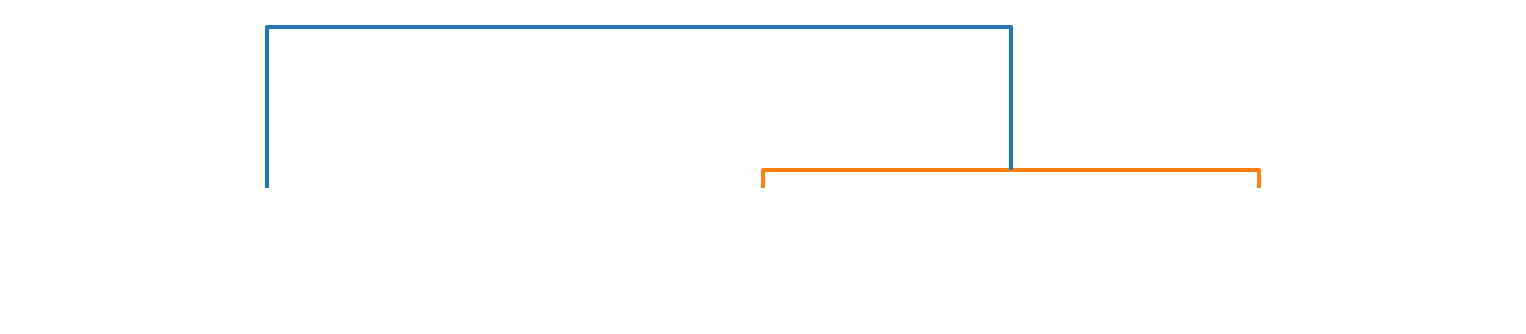

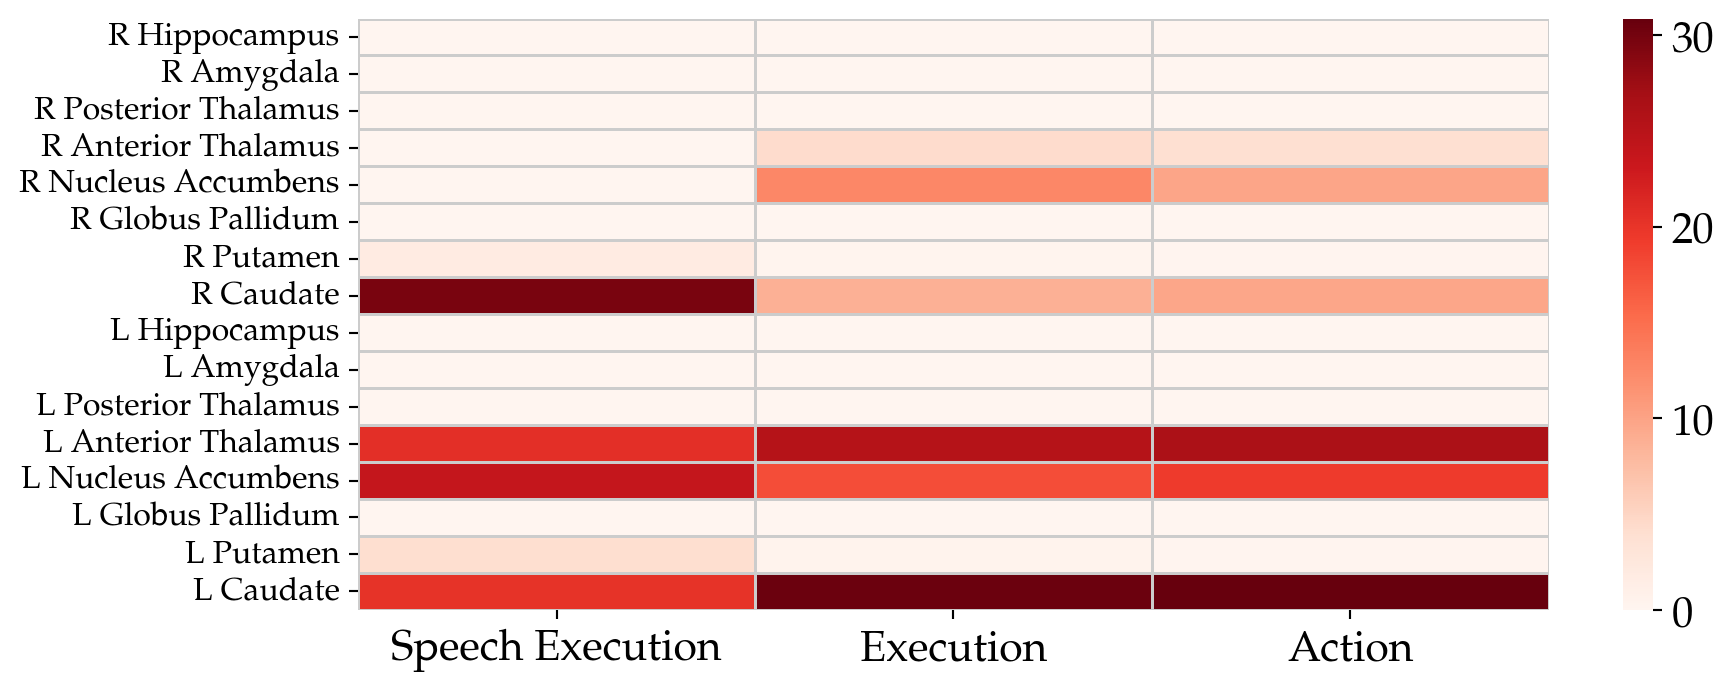

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(pct.T)

def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

# linkage matrix
linkage_matrix = create_linkage_matrix(model)

# plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(10, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
# ax.set_title("Hierarchical Clustering Dendrogram")
# ax.set_ylabel("Distance")
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7a_Tian2022_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)


# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
pct_reordered = pct_full.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(len(labels_clean))+0.5)
ax.set_yticklabels(labels_clean, rotation=0, fontsize=12)
ax.set_ylabel('')

# Save the heatmap to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7a_Tian2022_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

# Then the two cortical parcellations, starting with the Ji et al. (2019) networks

In [7]:
import pyvirtualdisplay
import brainspace.mesh, brainspace.plotting

def plot_surface(surface_data, mesh, itype=None, filename=None, 
        layout_style='row', cmap='viridis', vrange=None, cbar=False,
        nan_color=(0.75, 0.75, 0.75, 1), **plotter_kwargs):
    """
    Plots `surface_data` on `mesh` using brainspace

    Parameters
    ----------
    surface_data: (np.ndarray)
    mesh: (str | dict)
        - fsaverage
        - fsaverage5
        - dict of path to meshes for 'L' and 'R'
    itype: (str | None)
        mesh file type. For .gii enter None. For freesurfer files enter 'fs'
    filename: (Pathlike str)
    layout_style: (str)
        - row
        - grid
    cmap: (str)
    vrange: (tuple | None)
    nan_color: (tuple)
    **plotter_kwargs
    """
    # create virtual display for plotting in remote servers
    disp=pyvirtualdisplay.Display(visible=False)
    disp.start()
    # load surface mesh
    if isinstance(mesh, str):
        if mesh in ['fsaverage', 'fsaverage5']:
            mesh = {
                'L': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_left'],
                'R': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_right'],
            }
            itype = None
        else:
            raise ValueError("Unknown mesh")
    else:
        for fs_suffix in ['.pial', '.midthickness', '.white', '.inflated']:
            if mesh['L'].endswith(fs_suffix):
                itype = 'fs'
    if not os.path.exists(mesh['L']):
        raise ValueError("Mesh not found")
    lh_surf = brainspace.mesh.mesh_io.read_surface(mesh['L'], itype=itype)
    rh_surf = brainspace.mesh.mesh_io.read_surface(mesh['R'], itype=itype)
    # configurations
    if filename:
        screenshot = True
        embed_nb = False
        filename += '.png'
    else:
        screenshot = False
        embed_nb = True
    if layout_style == 'row':
        size = (1600, 400)
        zoom = 1.2
    else:
        size = (900, 500)
        zoom = 1.8
    if vrange is None:        
        vrange = (np.nanmin(surface_data), np.nanmax(surface_data))
    elif vrange == 'sym':
        vmin = min(np.nanmin(surface_data), -np.nanmax(surface_data))
        vrange = (vmin, -vmin)
    if cbar:
        plot_colorbar(vrange[0], vrange[1], cmap)
    return brainspace.plotting.surface_plotting.plot_hemispheres(
        lh_surf, rh_surf, 
        surface_data,
        layout_style = layout_style,
        cmap = cmap, color_range=vrange,
        # TODO: change size and zoom based on layout 
        size=size, zoom=zoom,
        interactive=False, embed_nb=embed_nb,
        screenshot=screenshot, filename=filename, 
        transparent_bg=True,
        nan_color=nan_color,
        **plotter_kwargs
        )

In [8]:
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Action/Action/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [9]:
tfile = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tfile)

macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
macm_fslr = np.concatenate([
    macm_fslr_gii[0].agg_data().flatten(),
    macm_fslr_gii[1].agg_data().flatten()
])

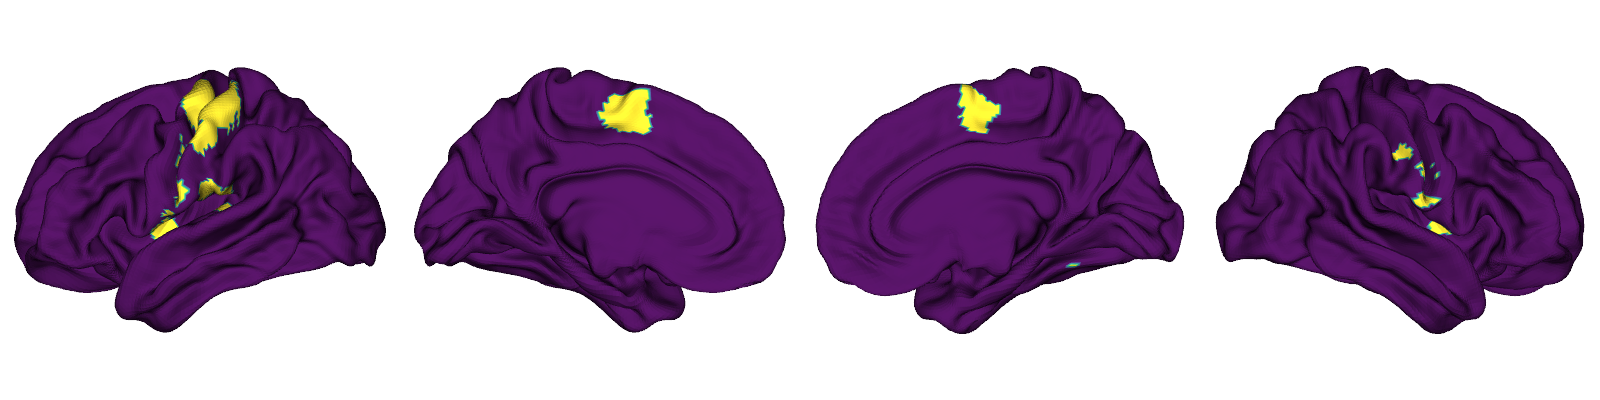

In [10]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

plot_surface(macm_fslr, meshes)

Does not look bad!
(Re)create the ColeAnticevic atlas in fsLR space using the Glasser parcellation and this file: https://github.com/ColeLab/ColeAnticevicNetPartition/blob/master/cortex_community_order.txt .

In [14]:
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3]=1
ca_cmap = LinearSegmentedColormap.from_list('CA', ca_colors, 13)
plt.register_cmap('CA', ca_cmap) # You only have to do this once

In [15]:
ca_ctx = hcp.cortex_data(hcp.ca_network['map_all'])

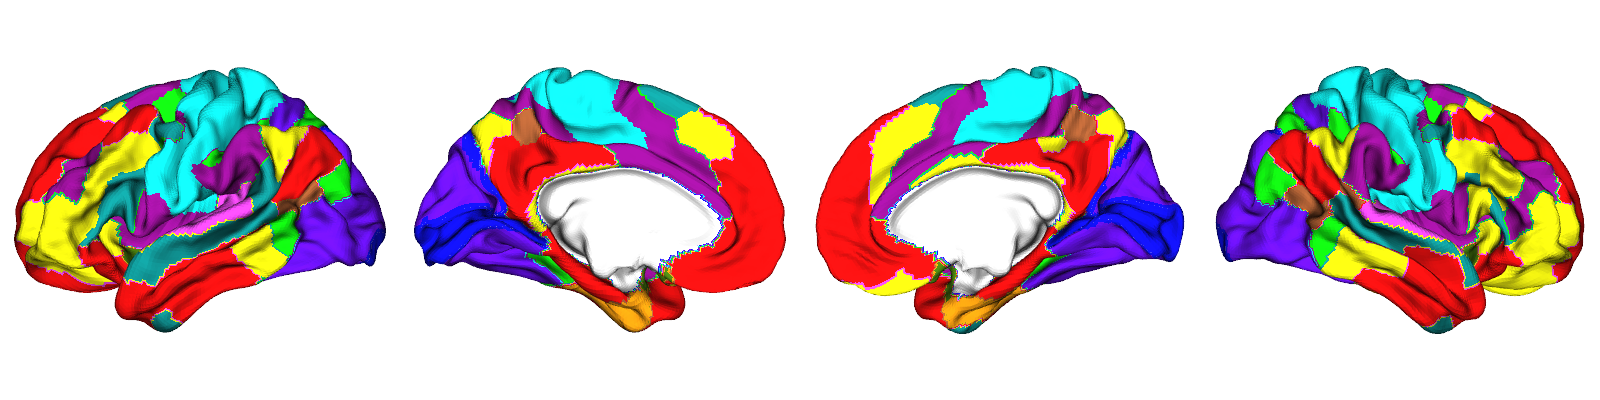

In [16]:
# Plot the surface. We saved this to file in the Figure 6 script.
plot_surface(ca_ctx, meshes, cmap='CA')

In [23]:
ca_labels = list(hcp.ca_network['labels'].values())[1:]

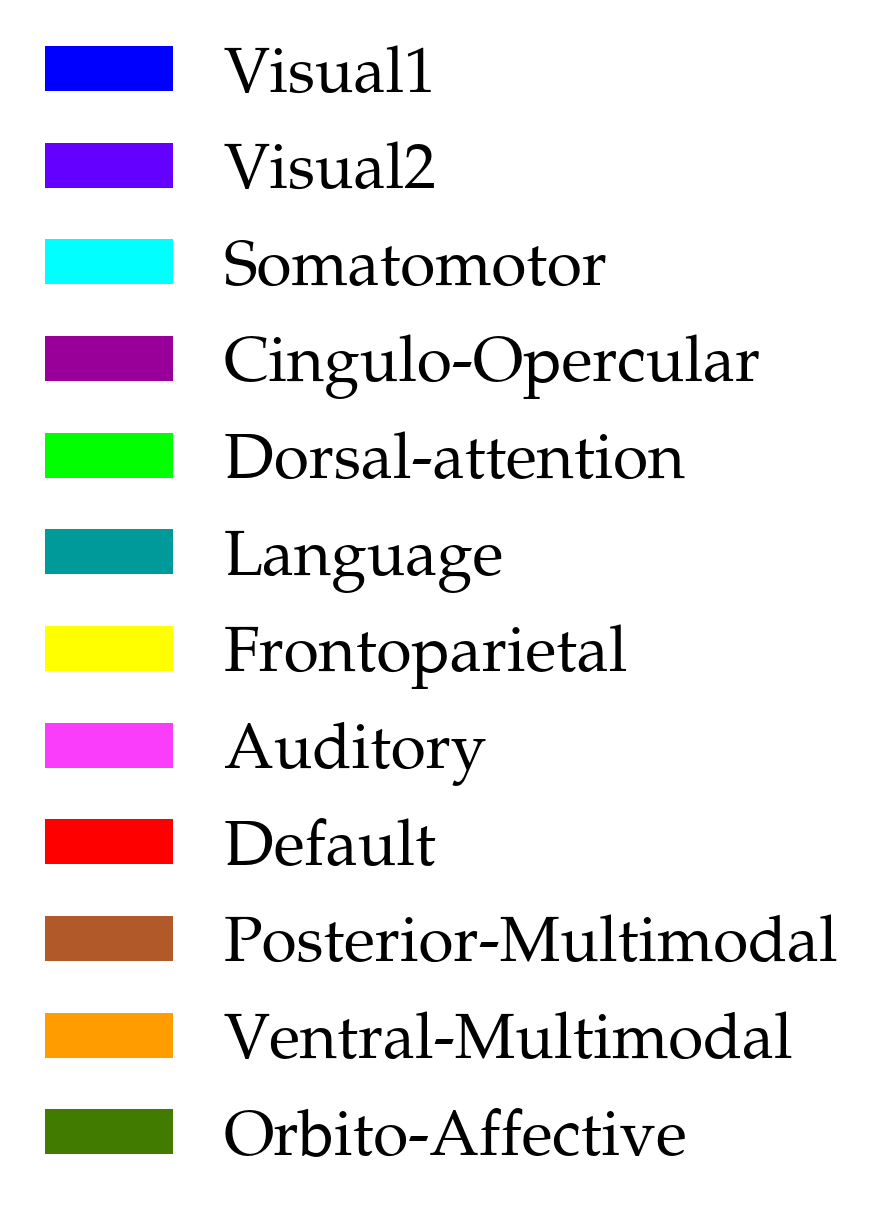

In [24]:
# Create a legend.
colors = dict(zip(ca_labels, ca_colors[1:])) # Skip 0
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

# Save the heatmap to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7b_Ji2019_labels.png'), bbox_inches='tight', dpi=300)

In [25]:
pd.DataFrame({
    'macm': macm_fslr.astype(bool),
    'ca': ca_ctx
}).groupby('macm')['ca'].value_counts()[(True, slice(None))]

ca
3.0    1420
4.0     534
8.0      49
5.0      33
6.0       9
2.0       2
Name: count, dtype: int64

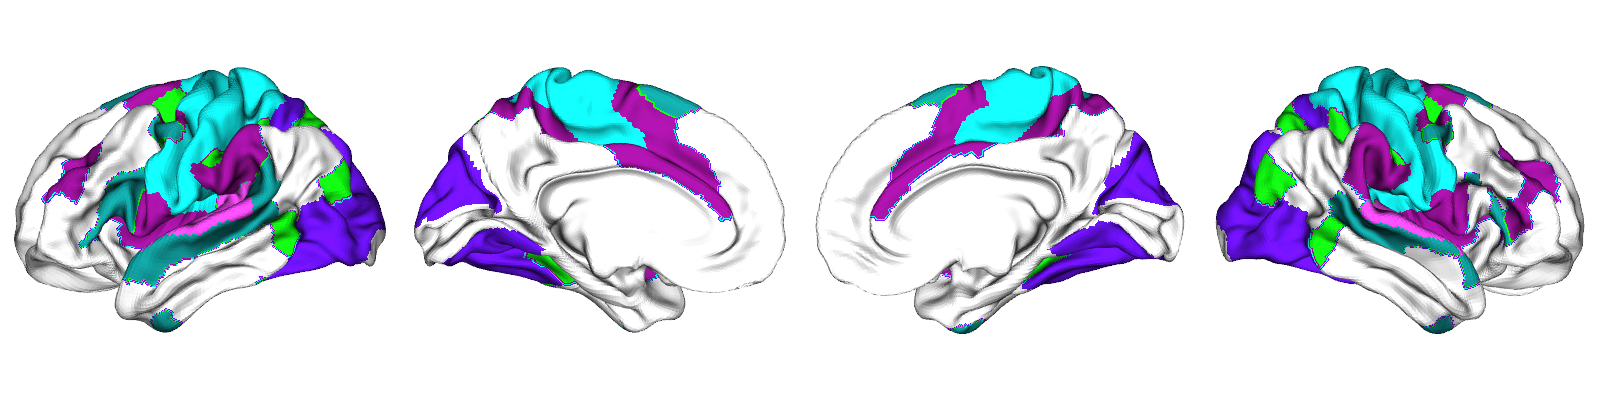

In [22]:
# We visualize just the CA-networks that have non-zero counts (Significant vertices).

ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3] = 1  # Ensure the background color is fully opaque
ca_cmap = LinearSegmentedColormap.from_list('CA', ca_colors, len(ca_colors))
# plt.register_cmap('CA', ca_cmap)  # Register the color map

ca_ctx = hcp.cortex_data(hcp.ca_network['map_all'])

# Define the selected indices
selected_indices = [2, 3, 4, 5, 6, 8] # Corresponds to non-zero data in the obs. counts dataframe.

# Create a mask for the selected indices
label_mask = np.isin(ca_ctx, selected_indices)

# Apply the mask to the cortical data (keeping background color for non-selected areas)
filtered_ca = np.zeros_like(ca_ctx)  # Background is set to 0 by default
for idx in selected_indices:
    filtered_ca[ca_ctx == idx] = idx  # Only retain selected indices

# Filter the colors to match the selected indices (skipping unused ones)
filtered_colors = [ca_colors[0]] + [ca_colors[i] for i in selected_indices]  # Include background color at index 0

# Create a new colormap with only the filtered colors}
filtered_cmap = LinearSegmentedColormap.from_list('Filtered_CA', filtered_colors, len(filtered_colors))
plt.register_cmap('Filtered_CA1', filtered_cmap)  # Register the new filtered colormap

# Plot the surface with the filtered data and colormap
plot_surface(filtered_ca, meshes, cmap='Filtered_CA1', filename= os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7b_Ji2019_parcellation_nonzero'))
plot_surface(filtered_ca, meshes, cmap='Filtered_CA1') # to visualize the map.

In [26]:
# Example selected indices
selected_indices = [2, 3, 4, 5, 6, 8]

# Assuming ca_labels starts from index 1 (since ca_labels[0] is excluded)
# Adjust indices to start from 0 for Python indexing
filtered_labels = [ca_labels[i - 1] for i in selected_indices]

print(filtered_labels)


['Visual2', 'Somatomotor', 'Cingulo-Opercular', 'Dorsal-attention', 'Language', 'Auditory']


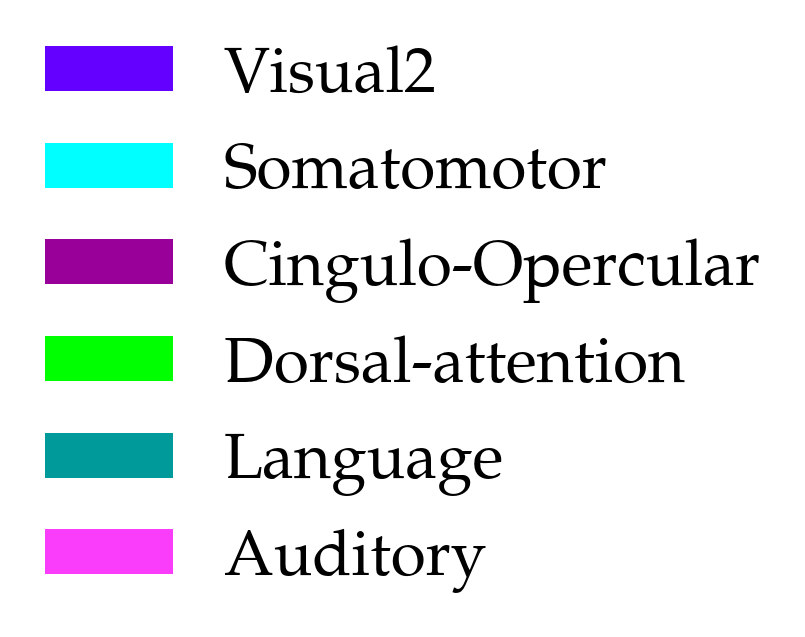

In [27]:
# Create a legend.
colors = dict(zip(filtered_labels, filtered_colors[1:])) # Skip 0

legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

# Save the heatmap to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7b_Ji2019_labels_nonzero.png'), bbox_inches='tight', dpi=300)

## Visualize Vision, to make sure the heatmap indexing went well (Vision maps 100 to 1 parcel).

In [28]:
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Perception/Perception.Vision/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [29]:
tfile = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tfile)

macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
macm_fslr = np.concatenate([
    macm_fslr_gii[0].agg_data().flatten(),
    macm_fslr_gii[1].agg_data().flatten()
])

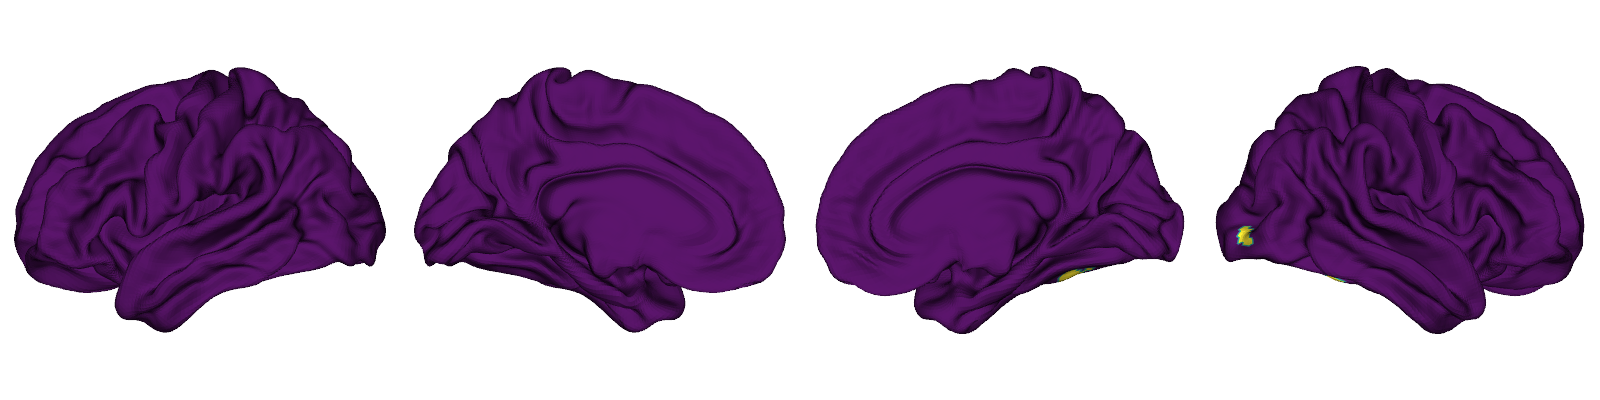

In [30]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

plot_surface(macm_fslr, meshes)

# Do it for all (sub)domains

In [31]:
# Define the valid domain-subdomain combinations. This is necessary since only a few MACM analyses had enough experiments to be valid (N > 15).
valid_combinations = [
    ('Action', 'Action'),
    ('Action', 'Action.Execution'),
    ('Action', 'Action.Execution.Speech'),
    ('Cognition', 'Cognition.Memory.Working'),
    ('Perception', 'Perception.Vision')
]

In [32]:
# Initialize an empty dictionary to store data
all_data = {}

# Compile a regular expression to match the file path pattern
pattern = re.compile(r'/SALE/([^/]+)/([^/]+)/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z\.nii\.gz')

# Iterate through the sorted file paths
for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    match = pattern.search(macm_path)
    
    if match:
        domain, subdomain = match.groups()
        if (domain, subdomain) in valid_combinations:
            # Binarize the MACM image
            macm_bin = nilearn.image.binarize_img(macm_path)
            
            # Transform to fsLR
            tfile = tempfile.mktemp('.nii.gz')
            macm_bin.to_filename(tfile)
            macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
            macm_fslr = np.concatenate([
                macm_fslr_gii[0].agg_data().flatten(),
                macm_fslr_gii[1].agg_data().flatten()
            ])
            
            # Proportion of each network within the MACM cluster(s)
            ca_in_macm = ca_ctx.copy()
            ca_in_macm[macm_fslr == 0] = np.NaN
            subbd_key = f'{domain}.{subdomain}' if domain != subdomain else domain
            all_data[subbd_key] = pd.Series(ca_in_macm.flatten()).value_counts().sort_index()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.29it/s]


In [34]:
all_data

{'Action.Action.Execution.Speech': 3.0    828
 4.0    132
 5.0      8
 6.0     16
 Name: count, dtype: int64,
 'Action.Action.Execution': 2.0       1
 3.0    1247
 4.0     539
 6.0      17
 8.0      69
 Name: count, dtype: int64,
 'Action': 2.0       2
 3.0    1420
 4.0     534
 5.0      33
 6.0       9
 8.0      49
 Name: count, dtype: int64,
 'Cognition.Cognition.Memory.Working': 3.0    52
 4.0     7
 6.0    17
 Name: count, dtype: int64,
 'Perception.Perception.Vision': 2.0    81
 Name: count, dtype: int64}

In [36]:
ca_counts = pd.DataFrame(all_data).T
ca_counts

# Ensure index is string type, then remove text before the first period
ca_counts.index = ca_counts.index.to_series().astype(str).apply(lambda x: x.split('.', 1)[1] if '.' in x else x)

# Display the modified DataFrame
print("\nCole-Anticevic Counts:")
print(ca_counts)


Cole-Anticevic Counts:
                           2.0     3.0    4.0   5.0   6.0   8.0
Action.Execution.Speech    NaN   828.0  132.0   8.0  16.0   NaN
Action.Execution           1.0  1247.0  539.0   NaN  17.0  69.0
Action                     2.0  1420.0  534.0  33.0   9.0  49.0
Cognition.Memory.Working   NaN    52.0    7.0   NaN  17.0   NaN
Perception.Vision         81.0     NaN    NaN   NaN   NaN   NaN


In [37]:
ca_counts = ca_counts.dropna(axis=0, how='all').fillna(0)
ca_pct = (ca_counts / ca_counts.values.sum(axis=1, keepdims=True)) * 100
ca_pct

2.0        3.0        4.0       5.0  \
Action.Execution.Speech     0.000000  84.146341  13.414634  0.813008   
Action.Execution            0.053390  66.577683  28.777363  0.000000   
Action                      0.097704  69.369809  26.086957  1.612115   
Cognition.Memory.Working    0.000000  68.421053   9.210526  0.000000   
Perception.Vision         100.000000   0.000000   0.000000  0.000000   

                                6.0       8.0  
Action.Execution.Speech    1.626016  0.000000  
Action.Execution           0.907635  3.683930  
Action                     0.439668  2.393747  
Cognition.Memory.Working  22.368421  0.000000  
Perception.Vision          0.000000  0.000000

# Create a heatmap visualisation

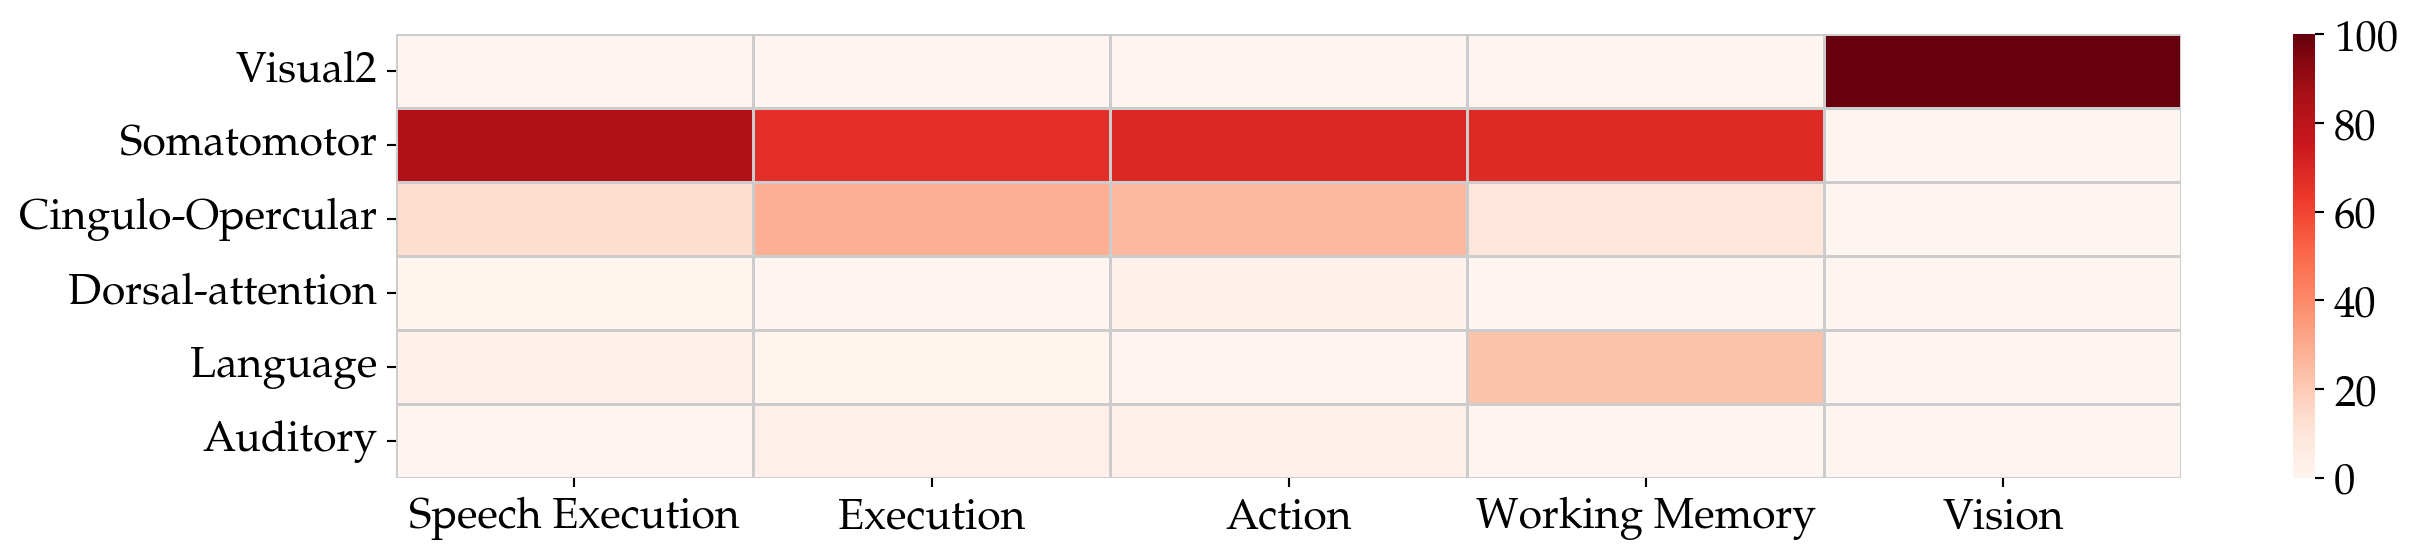

In [41]:
# With better labels
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Action.Execution.Speech': 'Speech Execution',
    'Action.Execution': 'Execution',
    'Cognition.Memory.Working': 'Working Memory',
    'Perception.Vision': 'Vision'
})


plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(ca_pct.T, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
ax.set_xticklabels(subdomain_labels.loc[ca_pct.index], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(filtered_labels, rotation=0)

# Save the heatmap to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7b_Ji2019_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

# Van Economo Cortical Types 

In [125]:
# We already have these in our inputs folder.

#!wget -O ../input/maps/lh_economo.annot https://github.com/amnsbr/laminar_organization/raw/master/src/lh_economo.annot
#!wget -O ../input/maps/rh_economo.annot https://github.com/amnsbr/laminar_organization/raw/master/src/rh_economo.annot
#!wget -O ../input/maps/economo_cortical_types.csv https://github.com/amnsbr/laminar_organization/raw/master/src/economo_cortical_types.csv

In [42]:
lh_parc_indices, _ , labels = nibabel.freesurfer.io.read_annot(os.path.join(INPUT_DIR, 'maps/lh_economo.annot'))
labels = [s.decode('utf-8') for s in labels]
lh_parc = np.vectorize(dict(enumerate(labels)).get)(lh_parc_indices)
rh_parc_indices, _ , labels = nibabel.freesurfer.io.read_annot(os.path.join(INPUT_DIR, 'maps/rh_economo.annot'))
labels = [s.decode('utf-8') for s in labels]
rh_parc = np.vectorize(dict(enumerate(labels)).get)(rh_parc_indices)
economo_fsa = np.concatenate([lh_parc, rh_parc])
economo_fsa

array(['FA', 'PE', 'FB', ..., 'TE', 'TE', 'TE'], dtype='<U7')

In [43]:
economo_ctypes = pd.read_csv(os.path.join(INPUT_DIR, 'maps/economo_cortical_types.csv'), index_col=0)
ctypes_fsa = (
    economo_ctypes.loc[economo_fsa]
    .reset_index(drop=True)
    .iloc[:, 0].astype('category')
    .cat.reorder_categories(['ALO', 'AG', 'DG', 'EU1', 'EU2', 'EU3', 'KO'])
)
ctypes_fsa.shape

(327684,)

In [44]:
lh_tf = tempfile.mktemp('.shape.gii')
lh_ctypes_fsa_gii = neuromaps.transforms.construct_shape_gii(ctypes_fsa.cat.codes.values[:ctypes_fsa.shape[0]//2])
lh_ctypes_fsa_gii.to_filename(lh_tf)
rh_tf = tempfile.mktemp('.shape.gii')
rh_ctypes_fsa_gii = neuromaps.transforms.construct_shape_gii(ctypes_fsa.cat.codes.values[ctypes_fsa.shape[0]//2:])
rh_ctypes_fsa_gii.to_filename(rh_tf)

In [45]:
ctypes_fsLR_gii = neuromaps.transforms.fsaverage_to_fslr((lh_tf, rh_tf), method='nearest')

In [12]:
# We already have these in our inputs.
# ctypes_fsLR_gii[0].to_filename(os.path.join(INPUT_DIR, 'maps/lh_ctypes_fsLR.shape.gii'))
# ctypes_fsLR_gii[1].to_filename(os.path.join(INPUT_DIR, 'maps/lh_ctypes_fsLR.shape.gii'))

In [46]:
ctypes_fsLR = np.concatenate([
    ctypes_fsLR_gii[0].agg_data(),
    ctypes_fsLR_gii[1].agg_data()
])
ctypes_fsLR[ctypes_fsLR < 1] = np.NaN # is set to -1 by codes
ctypes_fsLR.shape

(64984,)

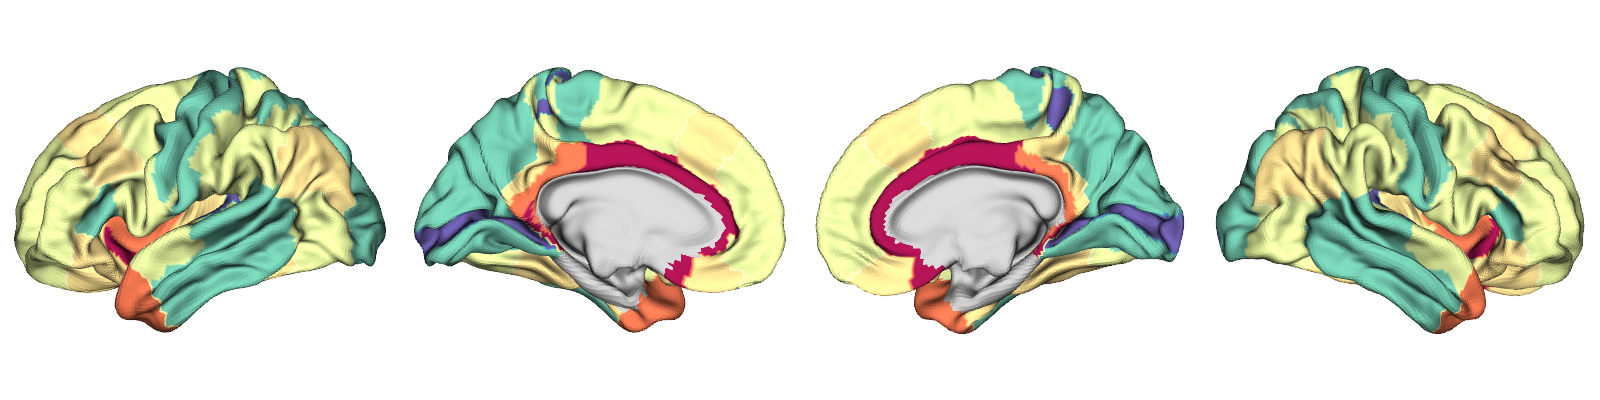

In [70]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

plot_surface(ctypes_fsLR, meshes, cmap='Spectral', filename= os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7c_CorticalTypes_parcellation'))
plot_surface(ctypes_fsLR, meshes, cmap='Spectral')

In [48]:
labels

['unknown',
 'corpuscallosum',
 'FA',
 'FB',
 'FC',
 'FCBm',
 'FD',
 'FDdelta',
 'FDT',
 'FE',
 'FF',
 'FG',
 'FH',
 'FJK',
 'FLMN',
 'HA',
 'HB',
 'HC',
 'IA',
 'IB',
 'LA1',
 'LA2',
 'LC1',
 'LC2',
 'LC3',
 'LD',
 'LE',
 'OA',
 'OB',
 'OC',
 'PA',
 'PB',
 'PC',
 'PD',
 'PE',
 'PF',
 'PG',
 'PH',
 'TA',
 'TB',
 'TC',
 'TD',
 'TE',
 'TF',
 'TG']

In [19]:
# Visualize Working Memory, since it maps primarily (~80%) to one cortical type. This is to make sure the indexing, and hence the heatmap, is correct

In [49]:
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Cognition/Cognition.Memory.Working/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Action BD-level.
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [50]:
tfile = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tfile)

macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
macm_fslr = np.concatenate([
    macm_fslr_gii[0].agg_data().flatten(),
    macm_fslr_gii[1].agg_data().flatten()
])

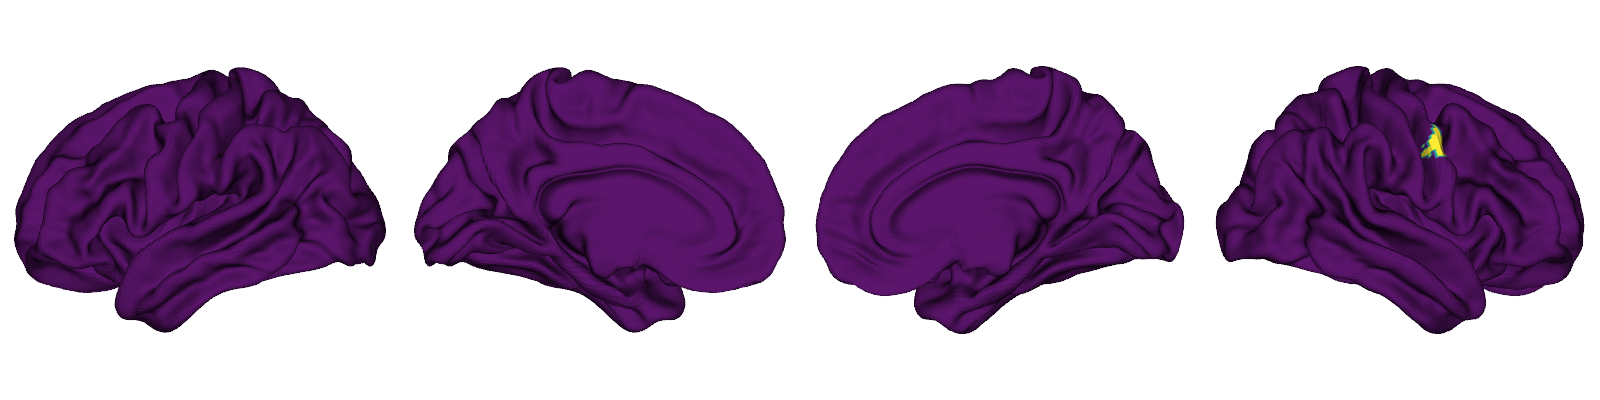

In [51]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

plot_surface(macm_fslr, meshes)

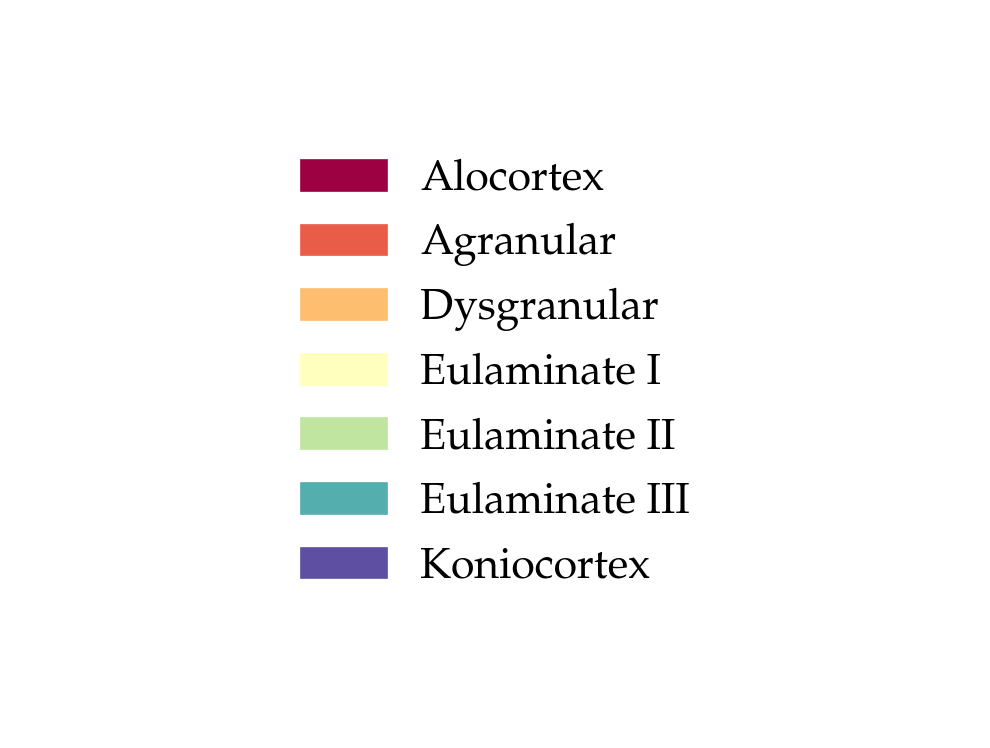

In [52]:
# Extract labels and corresponding colors
labels = ctypes_fsa.cat.categories

# Add full labels
ctype_labels = pd.Series({
    'ALO': 'Alocortex',
    'AG': 'Agranular',
    'DG': 'Dysgranular',
    'EU1': 'Eulaminate I',
    'EU2': 'Eulaminate II',
    'EU3': 'Eulaminate III',
    'KO': 'Koniocortex'
})

# Map the full labels to the abbreviated ones
mapped_labels = labels.map(ctype_labels)

cmap = plt.get_cmap('Spectral')
colors = [cmap(i / (len(mapped_labels) - 1)) for i in range(len(mapped_labels))]

# Create legend handles
handles = [mpatches.Patch(color=colors[i], label=mapped_labels[i]) for i in range(len(mapped_labels))]

# Create a new figure for the legend
fig = plt.figure()
ax = fig.add_subplot(111)  # Add a subplot to the figure
ax.axis('off')  # Hide the axis

# Add the legend to the figure
fig.legend(handles=handles, loc='center', frameon=False)

# Save the figure to a file
fig.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7c_CorticalTypes_Legend.png'), bbox_inches='tight')

# Show the legend (optional)
plt.show()

In [53]:
# We bring back the example macm
macm_nifti = os.path.join(OUTPUT_DIR, 'SALE/Action/Action/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
macm_bin = nilearn.image.binarize_img(macm_nifti)

In [54]:
tfile = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tfile)

macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
macm_fslr = np.concatenate([
    macm_fslr_gii[0].agg_data().flatten(),
    macm_fslr_gii[1].agg_data().flatten()
])

In [55]:
pd.DataFrame({
    'macm': macm_fslr.astype(bool),
    'ct': ctypes_fsLR
}).groupby('macm')['ct'].value_counts()[(True, slice(None))]

ct
4.0    1133
5.0     601
6.0     214
2.0      77
3.0      22
Name: count, dtype: int64

Spin test through numpy:

In [56]:
spin_idx = np.load(os.path.join(INPUT_DIR, 'maps/fsLR32k_spinidx_n-1000.npz'))['spin_idx']

In [57]:
null_counts = []

for i in tqdm(range(1000)):
    null_counts.append(
        pd.DataFrame({
            'macm': macm_fslr.astype(bool),
            'ct': ctypes_fsLR[spin_idx[:, i]]
        }).groupby('macm')['ct'].value_counts(sort=False)[(True, slice(None))]
        .rename(i)
    )

null_counts = pd.concat(null_counts, axis=1).sort_index().fillna(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 241.17it/s]


In [58]:
obs_counts = pd.DataFrame({
    'macm': macm_fslr.astype(bool),
    'ct': ctypes_fsLR
}).groupby('macm')['ct'].value_counts(sort=False)[(True, slice(None))].rename('obs')
# align it with null counts
obs_counts = pd.concat([null_counts, obs_counts], axis=1).fillna(0)[['obs']]
obs_counts

obs
ct         
1.0     0.0
2.0    77.0
3.0    22.0
4.0  1133.0
5.0   601.0
6.0   214.0

In [59]:
p = (np.abs(null_counts) >= np.abs(obs_counts.values)).mean(axis=1)
p

ct
1.0    1.000
2.0    0.349
3.0    0.950
4.0    0.142
5.0    0.456
6.0    0.125
dtype: float64

# For all (sub)domains

In [60]:
from tqdm import tqdm
obs_counts = {}
p = {}

for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # todo: use re
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    # binarize
    macm_bin = nilearn.image.binarize_img(macm_path)
    # transform to fsLR
    tfile = tempfile.mktemp('.nii.gz')
    macm_bin.to_filename(tfile)
    macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
    macm_fslr = np.concatenate([
        macm_fslr_gii[0].agg_data().flatten(),
        macm_fslr_gii[1].agg_data().flatten()
    ])
    # check if there are any significant cortical MACM regions
    if macm_fslr.sum() == 0:
        print(subbd, "has no significant cortical MACM vertices")
        continue
    # null counts
    null_counts = []
    for i in range(1000):
        null_counts.append(
            pd.DataFrame({
                'macm': macm_fslr.astype(bool),
                'ct': ctypes_fsLR[spin_idx[:, i]]
            }).groupby('macm')['ct'].value_counts(sort=False, dropna=False)[(True, slice(None))]
            .rename(i)
        )
    null_counts = pd.concat(null_counts, axis=1).sort_index().fillna(0)
    # observed counts
    obs_counts[subbd] = pd.DataFrame({
        'macm': macm_fslr.astype(bool),
        'ct': ctypes_fsLR
    }).groupby('macm')['ct'].value_counts(sort=False, dropna=False)[(True, slice(None))].rename('obs')
    # align it with null counts
    obs_counts[subbd] = pd.concat([null_counts, obs_counts[subbd]], axis=1).fillna(0)['obs']
    # p-value
    p[subbd] = (np.abs(null_counts) >= np.abs(obs_counts[subbd].values[:, None])).mean(axis=1)

obs_counts = pd.DataFrame(obs_counts)
p = pd.DataFrame(p)

 25%|██████████████████████████████████████▎                                                                                                                  | 3/12 [00:09<00:24,  2.73s/it]

Action.Observation has no significant cortical MACM vertices


 42%|███████████████████████████████████████████████████████████████▊                                                                                         | 5/12 [00:14<00:16,  2.36s/it]

Cognition.Language has no significant cortical MACM vertices


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 8/12 [00:24<00:10,  2.59s/it]

Emotion.Negative.Sadness has no significant cortical MACM vertices


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 9/12 [00:24<00:05,  1.88s/it]

Perception.Somesthesis has no significant cortical MACM vertices


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.24s/it]


In [33]:
obs_counts

Action.Execution.Speech  Action.Execution  Action  \
ct                                                       
1.0                      0.0               0.0     0.0   
2.0                      0.0              70.0    77.0   
3.0                      0.0              19.0    22.0   
4.0                    406.0            1057.0  1133.0   
5.0                    439.0             569.0   601.0   
6.0                    139.0             158.0   214.0   
NaN                      0.0               0.0     0.0   

     Cognition.Memory.Working  Cognition.SocialCognition  \
ct                                                         
1.0                       0.0                        0.0   
2.0                       0.0                      145.0   
3.0                       0.0                      104.0   
4.0                      15.0                      159.0   
5.0                      61.0                       94.0   
6.0                       0.0                        4.0   
NaN                       0.0                        0.0   

     Perception.Vision.Motion  Perception.Vision.Shape  Perception.Vision  
ct                                                                         
1.0                       0.0                      0.0                0.0  
2.0                       0.0                      0.0                0.0  
3.0                       0.0                     17.0               36.0  
4.0                       0.0                      0.0               10.0  
5.0                      18.0                      0.0               35.0  
6.0                       0.0                      0.0                0.0  
NaN                       0.0                      0.0                0.0

# Select just valid (sub)domains.

In [89]:
# Define the valid columns. This is necessary since only a few MACM analyses had enough experiments to be valid (N > 15).
valid_columns = ['Action',
                 'Action.Execution', 
                 'Action.Execution.Speech',
                 'Cognition.Memory.Working', 
                 'Perception.Vision'
]

# Filter the DataFrame to keep only the columns that are in the valid_subdomains list
obs_counts_filtered = obs_counts.loc[:, obs_counts.columns.isin(valid_columns)]

# Display the filtered DataFrame
print(obs_counts_filtered)

     Action.Execution.Speech  Action.Execution  Action  \
ct                                                       
1.0                      0.0               0.0     0.0   
2.0                      0.0              70.0    77.0   
3.0                      0.0              19.0    22.0   
4.0                    406.0            1057.0  1133.0   
5.0                    439.0             569.0   601.0   
6.0                    139.0             158.0   214.0   
NaN                      0.0               0.0     0.0   

     Cognition.Memory.Working  Perception.Vision  
ct                                                
1.0                       0.0                0.0  
2.0                       0.0                0.0  
3.0                       0.0               36.0  
4.0                      15.0               10.0  
5.0                      61.0               35.0  
6.0                       0.0                0.0  
NaN                       0.0                0.0  


In [90]:
p < 0.05

Action.Execution.Speech  Action.Execution  Action  \
ct                                                       
1.0                    False             False   False   
2.0                    False             False   False   
3.0                    False             False   False   
4.0                    False             False   False   
5.0                    False             False   False   
6.0                    False             False   False   
NaN                    False             False   False   

     Cognition.Memory.Working  Cognition.SocialCognition  \
ct                                                         
1.0                     False                      False   
2.0                     False                       True   
3.0                     False                      False   
4.0                     False                      False   
5.0                     False                      False   
6.0                     False                      False   
NaN                     False                      False   

     Perception.Vision.Motion  Perception.Vision.Shape  Perception.Vision  
ct                                                                         
1.0                     False                    False              False  
2.0                     False                    False              False  
3.0                     False                    False              False  
4.0                     False                    False              False  
5.0                     False                    False              False  
6.0                     False                    False              False  
NaN                     False                    False              False

In [146]:
obs_counts.to_csv(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Supplementary/macm_ctypes_counts.csv'))
p.to_csv(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Supplementary/macm_ctypes_spin-p.csv'))

In [64]:
ca_pct = (obs_counts_filtered / obs_counts_filtered.values.sum(axis=0, keepdims=True)) * 100

In [65]:
# remove NaN (Alocrotex has no significant vertices across valid (sub)domains.
ca_pct = ca_pct.drop(index=np.NaN)

In [67]:
ca_labels = list(ctypes_fsa.cat.categories)[1:]

Text(287.40104166666663, 0.5, '')

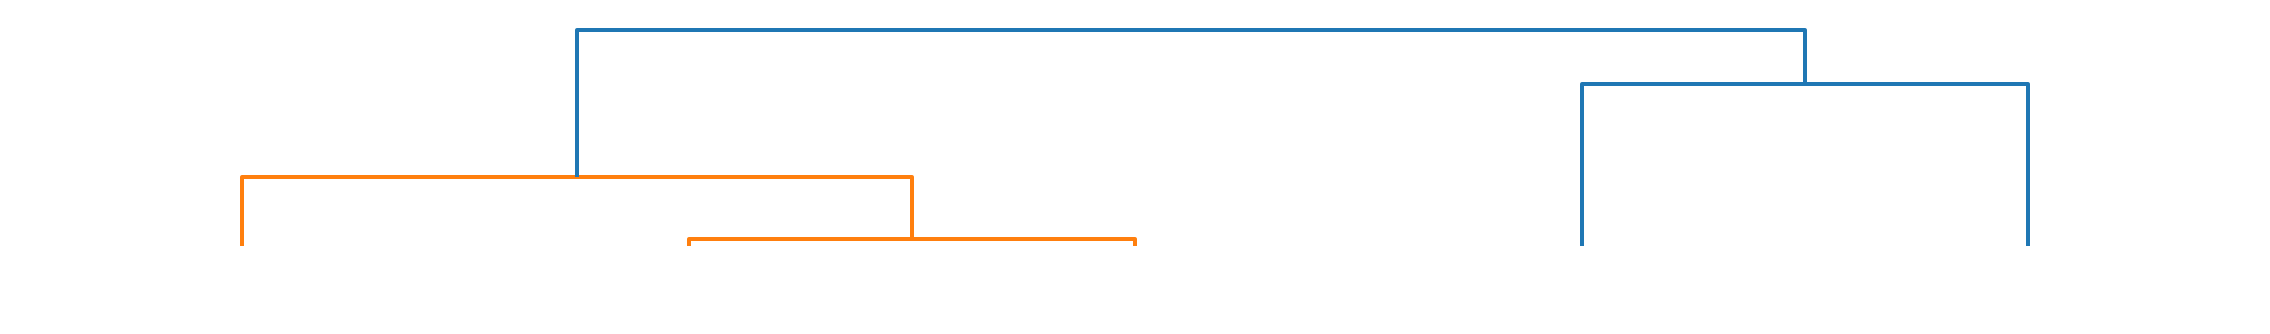

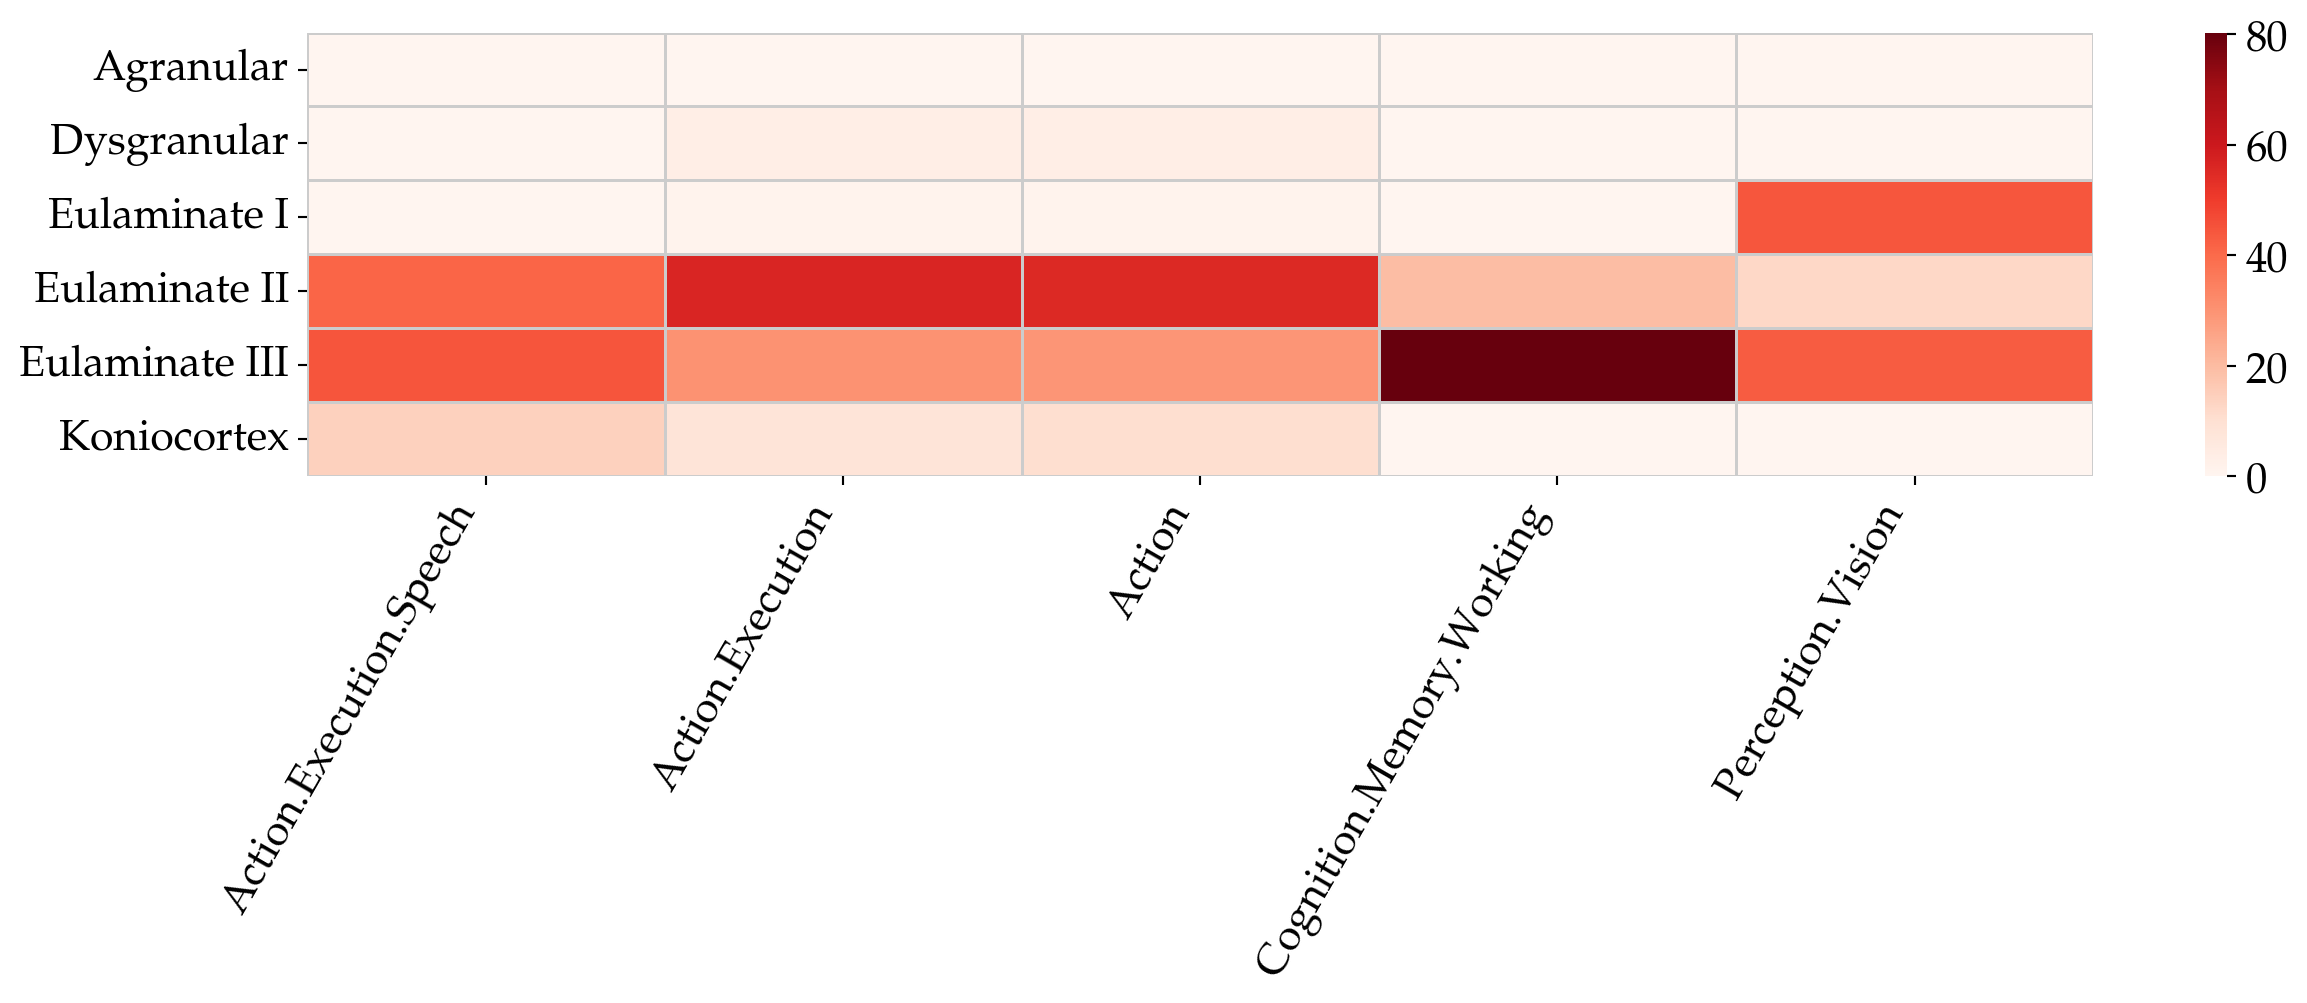

In [81]:
# code from chatgpt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Extract labels and corresponding colors
labels = ctypes_fsa.cat.categories[1:7]

# Add full labels
ctype_labels = pd.Series({
    # 'ALO': 'Alocortex', # Was empty
    'AG': 'Agranular',
    'DG': 'Dysgranular',
    'EU1': 'Eulaminate I',
    'EU2': 'Eulaminate II',
    'EU3': 'Eulaminate III',
    'KO': 'Koniocortex' 
})

# Map the full labels to the abbreviated ones
mapped_labels = labels.map(ctype_labels)


# hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(ca_pct.T)

def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

# linkage matrix
linkage_matrix = create_linkage_matrix(model)

# plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(15, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
# ax.set_title("Hierarchical Clustering Dendrogram")
# ax.set_ylabel("Distance")
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7c_Saberi23_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)

# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
ca_pct_reordered = ca_pct.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(ca_pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(mapped_labels, rotation=0)
ax.set_ylabel('')


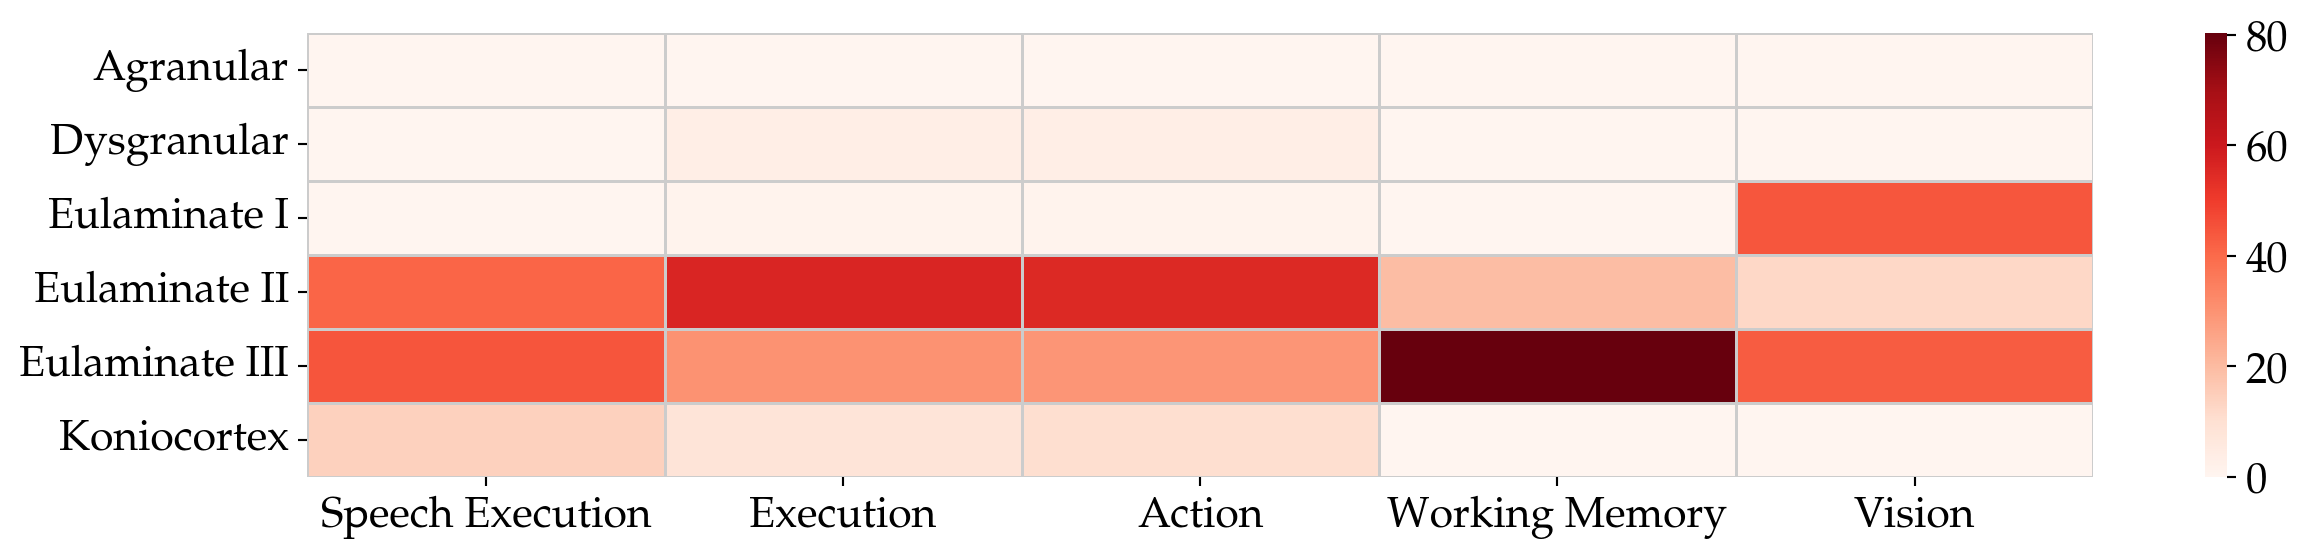

In [82]:
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Cognition': 'Cognition',
    'Action.MotorLearning': 'Motor Learning',
    'Action.Observation': 'Observation',
    'Action.Execution.Speech': 'Speech Execution',
    'Action.Inhibition': 'Inhibition',
    'Action.Execution': 'Execution',
    'Action.Preparation': 'Preparation',
    'Action.Imagination': 'Imagination',
    'Cognition.Spatial': 'Spatial',
    'Cognition.SocialCognition': 'Social Cognition',
    'Cognition.Attention': 'Attention',
    'Cognition.Language.Syntax': 'Syntax',
    'Cognition.Memory': 'Memory',
    'Cognition.Memory.Explicit': 'Explicit Memory',
    'Cognition.Language': 'Language',
    'Cognition.Language.Semantics': 'Semantics',
    'Cognition.Memory.Working': 'Working Memory',
    'Cognition.Language.Phonology': 'Phonology',
    'Cognition.Reasoning': 'Reasoning',
    'Cognition.Temporal': 'Temporal',
    'Cognition.Language.Speech': 'Speech',
    'Cognition.Language.Orthography': 'Orthography',
    'Cognition.Music': 'Music',
    'Emotion.Positive.RewardGain': 'Reward/ Gain',
    'Emotion.Negative.Disgust': 'Disgust',
    'Emotion.Positive': 'Positive Emotion',
    'Emotion.Negative.Fear': 'Fear',
    'Emotion.Positive.Happiness': 'Happiness',
    'Emotion.Negative.Sadness': 'Sadness',
    'Emotion.Negative': 'Negative Emotion',
    'Emotion.Valence': 'Valence',
    'Emotion.Negative.Anger': 'Anger',
    'Emotion.Negative.Anxiety': 'Anxiety',
    'Perception.Vision': 'Vision',
    'Perception.Olfaction': 'Olfaction',
    'Perception.Vision.Motion': 'Vision - Motion',
    'Perception.Gustation': 'Gustation',
    'Perception.Somesthesis.Pain': 'Pain',
    'Perception.Audition': 'Audition',
    'Perception.Somesthesis': 'Somesthesis',
    'Perception.Vision.Color': 'Vision - Color',
    'Perception.Vision.Shape': 'Vision - Shape',
    'Interoception.Sexuality': 'Sexuality',
    'Interoception.RespirationRegulation': 'Respiration Regulation',
    'Interoception.Hunger': 'Hunger'
})

ctype_labels = pd.Series({
    'ALO': 'Alocortex',
    'AG': 'Agranular',
    'DG': 'Dysgranular',
    'EU1': 'Eulaminate I',
    'EU2': 'Eulaminate II',
    'EU3': 'Eulaminate III'
    # 'KO': 'Koniocortex' # Is all Na
})
    

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(ca_pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
# ax.set_xticklabels(subdomain_labels.loc[ca_pct_reordered.columns], rotation=60, horizontalalignment='right')
ax.set_xticklabels(subdomain_labels.loc[ca_pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(mapped_labels, rotation=0)
ax.set_ylabel('')
# Save the dendrogram to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/7c_Saberi23_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

# The End.